In [1]:
!pip install tensorflow datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Installing Libraries
from datasets import load_dataset
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, Bidirectional, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np

In [3]:
# Load the SQuAD dataset
squad_2 = load_dataset('squad_v2')
train_data = squad_2['train']
val_data = squad_2['validation']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [4]:
# Initialize Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(
    [example['context'] for example in train_data] +
    [example['question'] for example in train_data] +
    [example['answers']['text'][0] for example in train_data if not example.get('is_impossible', False) and example['answers']['text']]
)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for padding

In [5]:
# Define maximum sequence lengths for context and question
max_context_len = 1000
max_question_len = 200

In [6]:
# Embedding dimensions and LSTM units
embedding_dim = 1000
hidden_size = 200

In [7]:
def preprocess_example(example):
    # Tokenize context and question
    context_tokens = tokenizer.texts_to_sequences([example['context']])[0]
    question_tokens = tokenizer.texts_to_sequences([example['question']])[0]

    # Pad sequences
    context_padded = pad_sequences([context_tokens], maxlen=max_context_len, padding='post')[0]
    question_padded = pad_sequences([question_tokens], maxlen=max_question_len, padding='post')[0]

    # Initialize start and end labels
    start_labels = [0] * max_context_len
    end_labels = [0] * max_context_len

    # Check if the question is answerable and that answers exist
    if not example.get('is_impossible', False) and example['answers']['text']:
        # If the question is answerable and has a valid answer, locate the answer tokens
        answer_text = example['answers']['text'][0]
        start_char = example['answers']['answer_start'][0]
        end_char = start_char + len(answer_text)

        # Find token start and end indices
        answer_tokens = tokenizer.texts_to_sequences([answer_text])[0]
        start_token_idx = None
        end_token_idx = None

        for idx in range(len(context_tokens) - len(answer_tokens) + 1):
            if context_tokens[idx:idx+len(answer_tokens)] == answer_tokens:
                start_token_idx = idx
                end_token_idx = idx + len(answer_tokens) - 1
                break

        # Set start and end labels if indices are found
        if start_token_idx is not None and end_token_idx is not None:
            start_labels[start_token_idx] = 1
            end_labels[end_token_idx] = 1

    return context_padded, question_padded, start_labels, end_labels


In [8]:
len(train_data)

130319

In [9]:
len(val_data)

11873

In [10]:
# Apply preprocessing to all examples in training data
# Initialize lists to store processed examples
train_processed = []
val_processed = []

# Process training data
for i in range(10000):
    processed_example = preprocess_example(train_data[i])
    if processed_example is not None:  # Only add if preprocessing was successful
        train_processed.append(processed_example)

# Process validation data
for i in range(2000):
    processed_example = preprocess_example(val_data[i])
    if processed_example is not None:  # Only add if preprocessing was successful
        val_processed.append(processed_example)

In [11]:
# Prepare input arrays
context_inputs = np.array([item[0] for item in train_processed])
question_inputs = np.array([item[1] for item in train_processed])
start_labels = np.array([item[2] for item in train_processed])
end_labels = np.array([item[3] for item in train_processed])


In [12]:
# Define the model
# Input layers
context_input = Input(shape=(max_context_len,), name='context_input')
question_input = Input(shape=(max_question_len,), name='question_input')

# Embedding layer (random initialization)
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True)

# Embed both inputs
context_embedding = embedding(context_input)
question_embedding = embedding(question_input)

# LSTM Encoding for Context and Question
context_lstm = Bidirectional(LSTM(units=hidden_size, return_sequences=True))(context_embedding)
question_lstm = Bidirectional(LSTM(units=hidden_size, return_sequences=True))(question_embedding)

# Attention Mechanism
attention = Attention()([context_lstm, question_lstm])

# Combine attention outputs with context
combined = Concatenate()([context_lstm, attention])

# LSTM for combining context and question information
lstm_combined = LSTM(units=hidden_size, return_sequences=True)(combined)

lstm_flattened = Flatten()(lstm_combined)
# Dropout layer
dropout = Dropout(0.3)(lstm_flattened)


# Output layers for start and end positions
start_output = Dense(max_context_len, activation='softmax', name='start_position')(dropout)
end_output = Dense(max_context_len, activation='softmax', name='end_position')(dropout)
# start_output = TimeDistributed(Dense(1, activation='softmax'), name='start_position')(dropout)
# end_output = TimeDistributed(Dense(1, activation='softmax'), name='end_position')(dropout)

# # Squeeze the last dimension to get shape (None, max_context_len)
# start_output = tf.squeeze(start_output, -1)
# end_output = tf.squeeze(end_output, -1)

In [13]:
def exact_match(y_true, y_pred):
    # Convert softmax predictions to integer indices (argmax)
    y_pred_idx = K.argmax(y_pred, axis=-1)
    y_true_idx = K.argmax(y_true, axis=-1)

    # Check if the predicted indices match the true indices
    matches = K.cast(K.equal(y_true_idx, y_pred_idx), dtype=tf.float32)

    # Calculate the mean across all samples to get the Exact Match rate
    return K.mean(matches)

In [14]:
# Define and compile the model
model = Model(inputs=[context_input, question_input], outputs=[start_output, end_output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics={'start_position': exact_match, 'end_position': exact_match})

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context_input             │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question_input            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 1000)      │     94,577,000 │ context_input[0][0],   │
│                           │                        │                │ question_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 1000, 400)      │      1,921,600 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 200, 400)       │      1,921,600 │ embedding[1][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 1000, 400)      │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1000, 800)      │              0 │ bidirectional[0][0],   │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 1000, 200)      │        800,800 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 200000)         │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 200000)         │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ start_position (Dense)    │ (None, 1000)           │    200,001,000 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ end_position (Dense)      │ (None, 1000)           │    200,001,000 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 499,223,000 (1.86 GB)

 Trainable params: 499,223,000 (1.86 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    [context_inputs, question_inputs],
    [start_labels, end_labels],
    batch_size=8,
    epochs=5,
    validation_split=0.1
)

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 486s 432ms/step - end_position_exact_match: 0.0669 - loss: 156.4920 - start_position_exact_match: 0.0681 - val_end_position_exact_match: 0.0030 - val_loss: 576.7813 - val_start_position_exact_match: 0.0020
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 502s 433ms/step - end_position_exact_match: 0.0504 - loss: 187.1536 - start_position_exact_match: 0.0516 - val_end_position_exact_match: 0.0170 - val_loss: 453.2782 - val_start_position_exact_match: 0.0040
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 501s 432ms/step - end_position_exact_match: 0.0662 - loss: 221.4185 - start_position_exact_match: 0.0691 - val_end_position_exact_match: 0.0060 - val_loss: 390.0206 - val_start_position_exact_match: 0.0090
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 502s 432ms/step - end_position_exact_match: 0.0933 - loss: 146.3302 - start_position_exact_match: 0.0947 - val_end_position_exact_match: 0.0050 - val_loss: 335.7929 - val_start_position_exact_match: 0.0280
Epoch 5/5
11

In [ ]:
def preprocess_inference(context, question):
    # Tokenize and pad context and question
    context_tokens = tokenizer.texts_to_sequences([context])[0]
    question_tokens = tokenizer.texts_to_sequences([question])[0]

    context_padded = pad_sequences([context_tokens], maxlen=max_context_len, padding='post')[0]
    question_padded = pad_sequences([question_tokens], maxlen=max_question_len, padding='post')[0]

    return np.array([context_padded]), np.array([question_padded]), context_tokens

def decode_answer(context_tokens, start_prob, end_prob):
    # Get the most probable start and end index
    start_index = np.argmax(start_prob)
    end_index = np.argmax(end_prob)

    # Ensure the end index comes after the start index
    if end_index < start_index:
        end_index = start_index

    # Convert token indices back to words
    answer_tokens = context_tokens[start_index:end_index+1]
    answer_words = tokenizer.sequences_to_texts([answer_tokens])[0]

    return answer_words

# Example context and question
context = "The Apollo program was the third United States human spaceflight program carried out by NASA, and the program responsible for the first humans landing on the Moon, from 1969 to 1972."
question = "What program was responsible for landing humans on the Moon?"

# Preprocess context and question
context_padded, question_padded, context_tokens = preprocess_inference(context, question)

# Perform inference
start_prob, end_prob = model.predict([context_padded, question_padded])

# Decode the answer from the model's output
answer = decode_answer(context_tokens, start_prob[0], end_prob[0])
print("Question:", question)
print("Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Question: What program was responsible for landing humans on the Moon?
Answer: apollo program was the third united states human spaceflight program carried out by nasa


In [ ]:
from tensorflow.keras.utils import plot_model

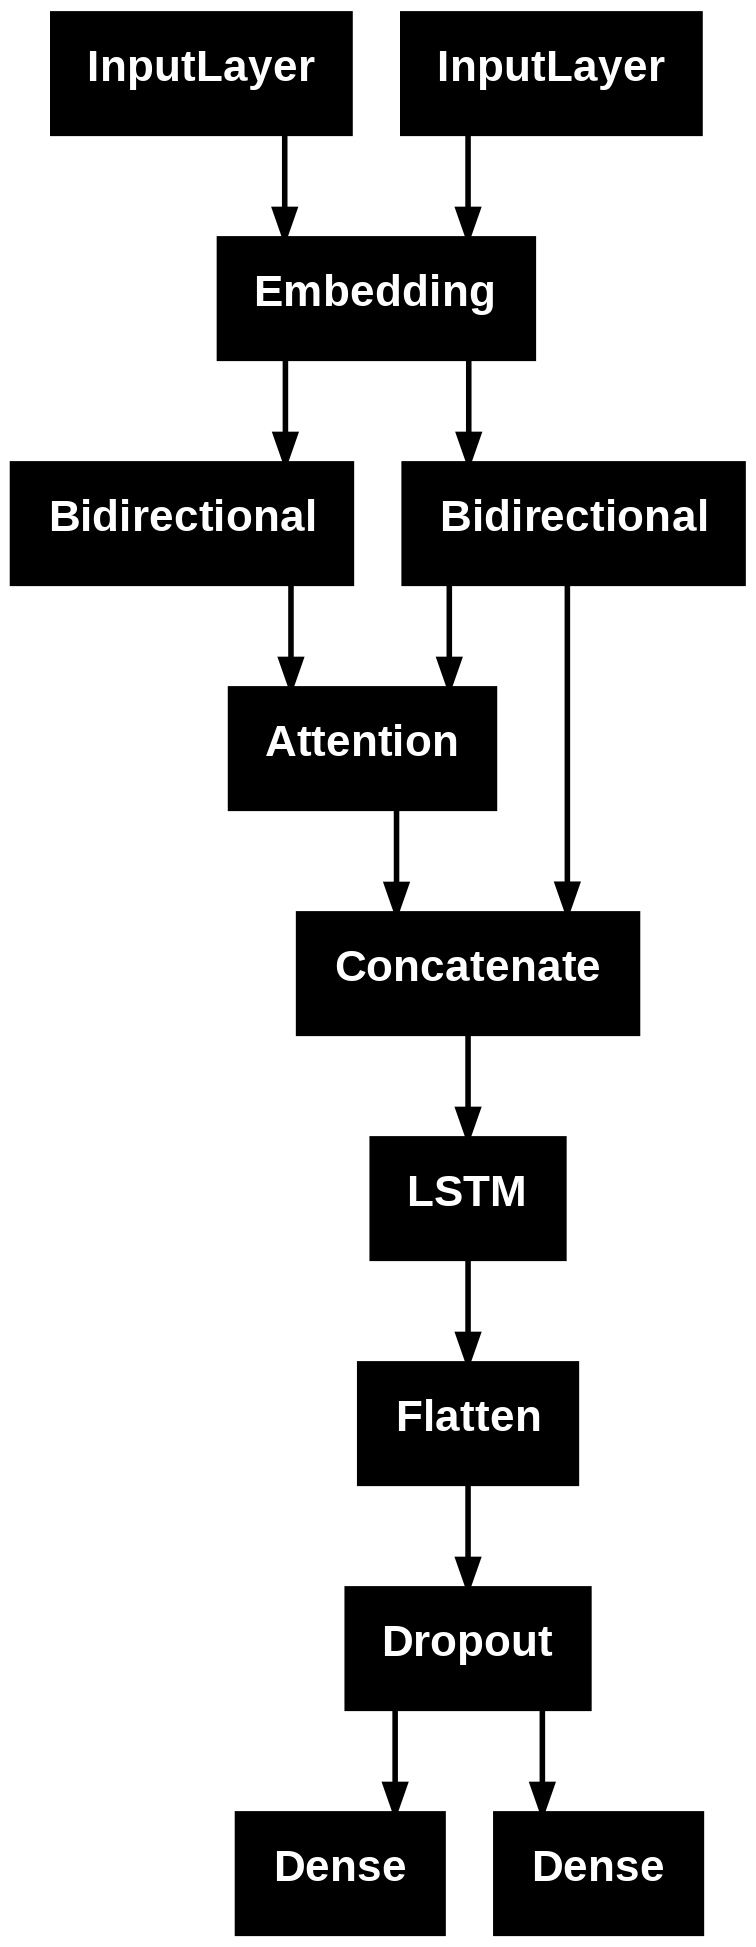

In [ ]:
plot_model(model)